In [1]:
from keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dot, Add, Multiply, Subtract, Average, Reshape
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping

In [2]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [3]:
df=pd.read_pickle('/home/elena/Projects/DLRM-with-Keras-for-movielens-dataset/ratings_movie_info.pkl')

In [4]:
df.describe()

,user_id,movie_id,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [5]:
df.dtypes

user_id             int64
movie_id            int64
rating            float64
unix_timestamp     object
title              object
genre              object
dtype: object

In [6]:
from sklearn.model_selection import train_test_split
import math

In [7]:
# train test split
# Shuffle (reproducibly)
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

# Partitioning train/val according to behaviour of keras.Model.fit() when called with
# validation_split kwarg (which is to take validation data from the end as a contiguous
# chunk)
val_split = .1
n_ratings = len(df)
n_train = math.floor(n_ratings * (1-val_split))
itrain = df.index[:n_train]
ival = df.index[n_train:]
train=df.loc[itrain]
test=df.loc[ival]

In [8]:
train.shape, test.shape, train.user_id.unique().shape[0], test.user_id.unique().shape[0]

((90752, 6), (10084, 6), 610, 597)

In [8]:
len(set(test.user_id.unique()).intersection(set(train.user_id.unique())))

597

In [9]:
len(set(test.user_id.unique()).difference(set(train.user_id.unique())))

0

In [10]:
# center rating
mean_rating_train =  df.loc[itrain, 'rating'].mean()
df['y'] = df['rating'] -mean_rating_train

In [11]:
df.head()

,user_id,movie_id,rating,unix_timestamp,title,genre,y
0,600,587,3.0,1237715109,Ghost (1990),Comedy|Drama|Fantasy|Romance|Thriller,-0.503344
1,68,6193,3.5,1240093148,Poolhall Junkies (2002),Comedy|Drama|Thriller,-0.003344
2,63,357,4.0,1443201224,Four Weddings and a Funeral (1994),Comedy|Romance,0.496656
3,139,8368,3.0,1453924202,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,-0.503344
4,483,1479,4.5,1181495506,"Saint, The (1997)",Action|Romance|Sci-Fi|Thriller,0.996656


In [12]:
hidden_units = (32,4)
movie_embedding_size = 8
user_embedding_size = 8

# Each instance will consist of two inputs: a single user id, and a single movie id
user_id_input = Input(shape=(1,), name='user_id')
movie_id_input = Input(shape=(1,), name='movie_id')
user_embedded = Embedding(df.user_id.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = Embedding(df.movie_id.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
# Concatenate the embeddings (and remove the useless extra dimension)
concatenated = Concatenate()([user_embedded, movie_embedded])
out = Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = Dense(1, activation='linear', name='prediction')(out)

model = Model(inputs = [user_id_input, movie_id_input],outputs = out)
model.summary(line_length=88)

Model: "functional_1"
________________________________________________________________________________________
Layer (type)                 Output Shape       Param #   Connected to                  
user_id (InputLayer)         [(None, 1)]        0                                       
________________________________________________________________________________________
movie_id (InputLayer)        [(None, 1)]        0                                       
________________________________________________________________________________________
user_embedding (Embedding)   (None, 1, 8)       4888      user_id[0][0]                 
________________________________________________________________________________________
movie_embedding (Embedding)  (None, 1, 8)       1548880   movie_id[0][0]                
________________________________________________________________________________________
concatenate (Concatenate)    (None, 1, 16)      0         user_embedding[0][0]          

In [13]:
model.compile(optimizer = 'Adam',loss='MSE',metrics=['MAE'])

In [14]:
es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)

In [15]:
history=model.fit(x=[df.user_id, df.movie_id], y=df.y, batch_size=500,epochs=20, verbose=1, validation_split=0.15, callbacks=[es])

Epoch 1/20
172/172 [==============================] - 3s 17ms/step - loss: 0.9525 - MAE: 0.7617 - val_loss: 0.8046 - val_MAE: 0.6890
Epoch 2/20
172/172 [==============================] - 3s 16ms/step - loss: 0.7384 - MAE: 0.6583 - val_loss: 0.7522 - val_MAE: 0.6662
Epoch 3/20
172/172 [==============================] - 2s 14ms/step - loss: 0.6833 - MAE: 0.6307 - val_loss: 0.7430 - val_MAE: 0.6599
Epoch 4/20
172/172 [==============================] - 3s 15ms/step - loss: 0.6578 - MAE: 0.6177 - val_loss: 0.7359 - val_MAE: 0.6579
Epoch 5/20
172/172 [==============================] - 3s 15ms/step - loss: 0.6397 - MAE: 0.6075 - val_loss: 0.7336 - val_MAE: 0.6535
Epoch 6/20
172/172 [==============================] - 3s 15ms/step - loss: 0.6272 - MAE: 0.6009 - val_loss: 0.7335 - val_MAE: 0.6522
Epoch 7/20
172/172 [==============================] - 3s 15ms/step - loss: 0.6174 - MAE: 0.5953 - val_loss: 0.7307 - val_MAE: 0.6521
Epoch 8/20
172/172 [==============================] - 3s 15ms/step - 

In [16]:
def get_metrics(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred), metrics.mean_squared_error(y_true, y_pred)

mean_rating = train['rating'].mean()
print("Average rating in training set is {:.2f} stars".format(mean_rating))

y_true = test['rating'].values
always_mean = np.full(y_true.shape, mean_rating)

mae, mse = get_metrics(y_true, always_mean)
print("Always predicting global average rating results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(
    mae, mse))

movies = df.copy().set_index('movie_id')
mean_per_movie = train.groupby('movie_id')['rating'].mean()
movies['mean_rating'] = mean_per_movie
ratings_per_movie = train.groupby('movie_id').size()
movies['n_ratings'] = ratings_per_movie
# There are a few movies in the validation set not present in the training set. We'll just use the global
# mean rating in their case.
y_movie_mean = test.join(mean_per_movie, on='movie_id', rsuffix='mean')['ratingmean'].fillna(mean_rating).values

mae, mse = get_metrics(y_true, y_movie_mean)
print("Predicting mean per movie results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

Average rating in training set is 3.50 stars
Always predicting global average rating results in Mean Absolute Error=0.83, Mean Squared Error=1.10
Predicting mean per movie results in Mean Absolute Error=0.76, Mean Squared Error=0.96


In [17]:
import matplotlib.pyplot as plt

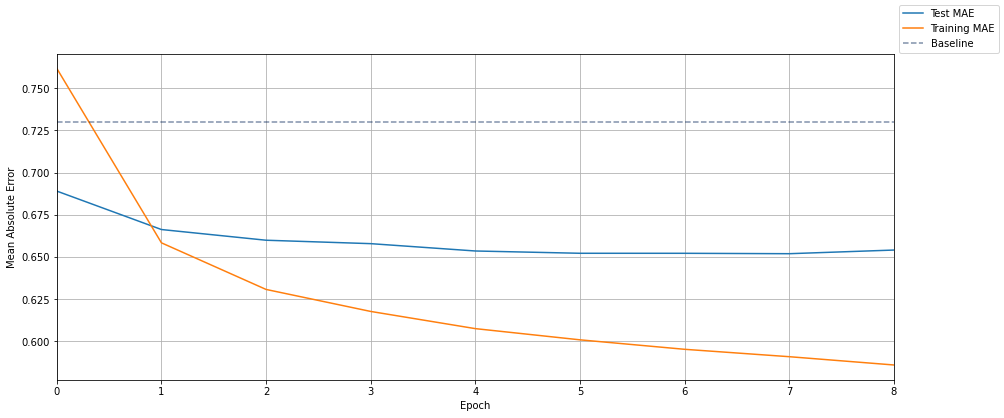

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_MAE'], label='Test MAE')
ax.plot(history.epoch, history.history['MAE'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

In [19]:
#Example predictions
ratings_per_user = df.groupby('user_id').size()
uid = ratings_per_user[ratings_per_user < 30].sample(1, random_state=1).index[0]
user_ratings = df[df.user_id==uid]
print("User #{} has rated {} movies (avg. rating = {:.1f}):".format(
    uid, len(user_ratings), user_ratings['rating'].mean(),
))
cols = ['user_id', 'movie_id', 'rating', 'title', 'genre']
user_ratings.sort_values(by='rating', ascending=False)[cols]

User #557 has rated 27 movies (avg. rating = 3.9):


,user_id,movie_id,rating,title,genre
87002,557,5618,5.0,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy
15710,557,1036,5.0,Die Hard (1988),Action|Crime|Thriller
17227,557,165,5.0,Die Hard: With a Vengeance (1995),Action|Crime|Thriller
60899,557,648,5.0,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
1465,557,2617,4.5,"Mummy, The (1999)",Action|Adventure|Comedy|Fantasy|Horror|Thriller
42863,557,1485,4.5,Liar Liar (1997),Comedy
73123,557,10,4.5,GoldenEye (1995),Action|Adventure|Thriller
71576,557,318,4.5,"Shawshank Redemption, The (1994)",Crime|Drama
47020,557,2571,4.5,"Matrix, The (1999)",Action|Sci-Fi|Thriller
94918,557,4896,4.5,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy


In [33]:
candidate_movies = df[(df.genre.str.contains('Action')) & (df.genre.str.contains('Thriller')) & (df.genre.str.contains('Crime')) & (df.genre.str.contains('Adventure')) ].copy()

In [73]:
best_ratings = candidate_movies.groupby('title').mean().sort_values(by='rating', ascending=False)[:4]

In [74]:
best_ratings

,user_id,movie_id,rating,y
title,,,,
City of God (Cidade de Deus) (2002),313.066667,6016.0,4.146667,0.643322
"Warriors, The (1979)",279.875000,7802.0,3.937500,0.434156
Blood Diamond (2006),339.207547,49530.0,3.764151,0.260807
Sherlock Holmes: A Game of Shadows (2011),297.578947,91542.0,3.763158,0.259814


In [107]:
result = pd.DataFrame()
result['title'] = best_ratings.index 
result['mean_rating'] = best_ratings.rating.values

In [108]:
# we need the movie ids
result

,title,mean_rating
0,City of God (Cidade de Deus) (2002),4.146667
1,"Warriors, The (1979)",3.937500
2,Blood Diamond (2006),3.764151
3,Sherlock Holmes: A Game of Shadows (2011),3.763158


In [109]:
movies_filter =  df['title'].isin(list(best_ratings.index[:4]))

In [110]:
movies=df[movies_filter]

In [111]:
movies = movies[['title','movie_id']]
movies = movies.drop_duplicates()

In [112]:
movies

,title,movie_id
108,Blood Diamond (2006),49530
714,City of God (Cidade de Deus) (2002),6016
4216,Sherlock Holmes: A Game of Shadows (2011),91542
13261,"Warriors, The (1979)",7802


In [116]:
reuslt2 = pd.merge(result, movies, on='title')

In [117]:
reuslt2

,title,mean_rating,movie_id
0,City of God (Cidade de Deus) (2002),4.146667,6016
1,"Warriors, The (1979)",3.937500,7802
2,Blood Diamond (2006),3.764151,49530
3,Sherlock Holmes: A Game of Shadows (2011),3.763158,91542


In [119]:
reuslt2['user'] = uid

In [120]:
reuslt2

,title,mean_rating,movie_id,user
0,City of God (Cidade de Deus) (2002),4.146667,6016,557
1,"Warriors, The (1979)",3.937500,7802,557
2,Blood Diamond (2006),3.764151,49530,557
3,Sherlock Holmes: A Game of Shadows (2011),3.763158,91542,557


In [121]:
preds=model.predict([reuslt2.user, reuslt2.movie_id])

In [122]:
row = df.iloc[2] # The difference between rating and y will be the same for all rows, so we can just use the third
y_delta = row.rating - row.y

In [123]:
y_delta

3.5033442789139633

In [125]:
reuslt2['predicted_rating'] = preds + y_delta
# Add a column with the difference between our predicted rating (for this user) and the movie's
# overall average rating across all users in the dataset.
reuslt2['delta'] = reuslt2['predicted_rating'] - reuslt2['mean_rating']
reuslt2.sort_values(by='delta', ascending=False)

,title,mean_rating,movie_id,user,predicted_rating,delta
2,Blood Diamond (2006),3.764151,49530,557,3.746433,-0.017718
3,Sherlock Holmes: A Game of Shadows (2011),3.763158,91542,557,3.704993,-0.058165
0,City of God (Cidade de Deus) (2002),4.146667,6016,557,4.083444,-0.063223
1,"Warriors, The (1979)",3.937500,7802,557,3.865303,-0.072197
